In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data_bersih_klasifikasi - data_bersih_klasifikasi.csv")

texts = df['cleaned_nostop'].astype(str)
labels = df['fine_tuned_label']

In [ ]:
VOCAB_SIZE = 15000
MAXLEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post')

In [ ]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, encoded_labels, test_size=0.2, random_state=42
)

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

##**LSTM**##

In [ ]:
unidirectional_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAXLEN),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.0003)
unidirectional_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

unidirectional_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unidirectional_history = unidirectional_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.5018 - loss: 1.0443 - val_accuracy: 0.5072 - val_loss: 1.0369 - learning_rate: 3.0000e-04
Epoch 2/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5021 - loss: 1.0408 - val_accuracy: 0.5072 - val_loss: 1.0353 - learning_rate: 3.0000e-04
Epoch 3/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5059 - loss: 1.0386 - val_accuracy: 0.5072 - val_loss: 1.0353 - learning_rate: 3.0000e-04
Epoch 4/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5004 - loss: 1.0407 - val_accuracy: 0.5072 - val_loss: 1.0361 - learning_rate: 3.0000e-04
Epoch 5/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5063 - loss: 1.0368 - val_accuracy: 0.5072 - val_loss: 1.0355 - learning_rate: 1.5000e-04


In [ ]:
loss, accuracy = unidirectional_model.evaluate(X_test, y_test)
print(f"Akurasi pada data uji: {accuracy:.4f}")

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5016 - loss: 1.0381
Akurasi pada data uji: 0.5009


In [ ]:
def prediksi_sentimen(model, kalimat):
    # Tokenisasi dan padding
    seq = tokenizer.texts_to_sequences([kalimat])
    padded = pad_sequences(seq, maxlen=MAXLEN, padding='post', truncating='post')

    # Prediksi
    pred = model.predict(padded)
    label_index = np.argmax(pred)
    label = label_encoder.inverse_transform([label_index])[0]

    print(f"Kalimat   : {kalimat}")
    print(f"Sentimen  : {label} ({pred[0][label_index]:.4f})")

    return label

prediksi_sentimen(unidirectional_model, "Bagus")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Kalimat   : Bagus
Sentimen  : LABEL_1 (0.4920)


'LABEL_1'

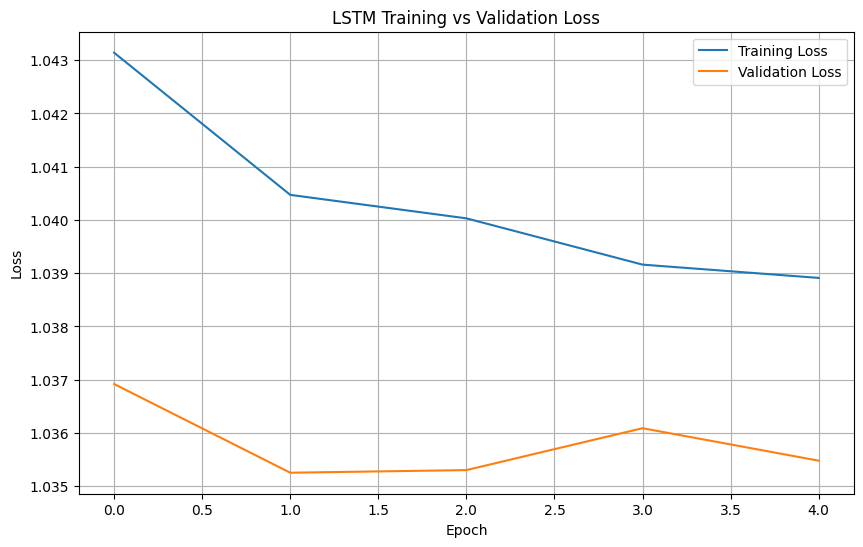

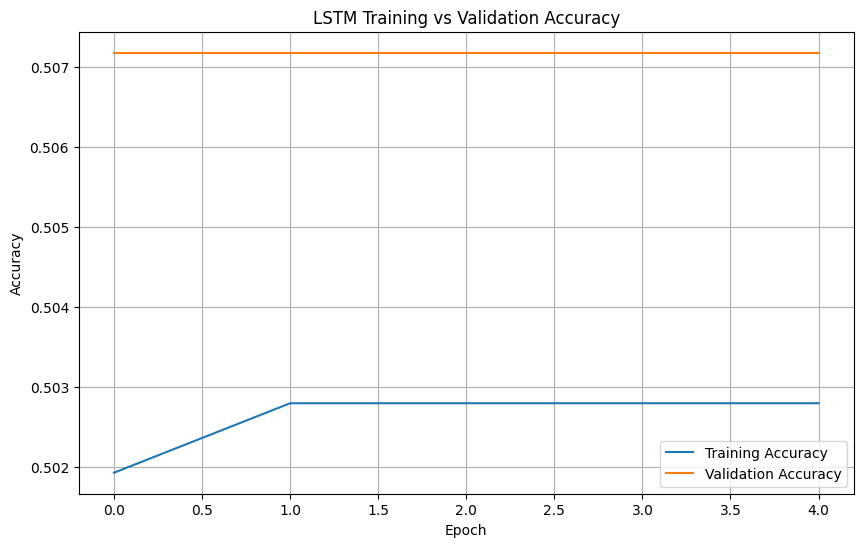

In [ ]:
# Plot loss dan val_loss
plt.figure(figsize=(10, 6))
plt.plot(unidirectional_history.history['loss'], label='Training Loss')
plt.plot(unidirectional_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot akurasi
plt.figure(figsize=(10, 6))
plt.plot(unidirectional_history.history['accuracy'], label='Training Accuracy')
plt.plot(unidirectional_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
unidirectional_model.save('/content/drive/MyDrive/Colab Notebooks/Skripsian/Praktikum Deep Learning 2025/MA4072-TugasBesarPembelajaranMendalam-10121040-10121091/Kerjaan Bryan/model_lstm.h5')

##**Bidirectional LSTM**##

In [ ]:
bidirectional_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=MAXLEN),
    Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
bidirectional_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

bidirectional_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
bidirectional_history = bidirectional_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 604s 753ms/step - accuracy: 0.5691 - loss: 0.9222 - val_accuracy: 0.7011 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 2/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 597s 753ms/step - accuracy: 0.7560 - loss: 0.5972 - val_accuracy: 0.6994 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 3/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 602s 759ms/step - accuracy: 0.8036 - loss: 0.4862 - val_accuracy: 0.7069 - val_loss: 0.6942 - learning_rate: 0.0010
Epoch 4/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 614s 775ms/step - accuracy: 0.8380 - loss: 0.4206 - val_accuracy: 0.6953 - val_loss: 0.7638 - learning_rate: 0.0010
Epoch 5/20
793/793 ━━━━━━━━━━━━━━━━━━━━ 618s 779ms/step - accuracy: 0.8610 - loss: 0.3675 - val_accuracy: 0.6983 - val_loss: 0.8489 - learning_rate: 5.0000e-04


In [ ]:
loss, accuracy = bidirectional_model.evaluate(X_test, y_test)
print(f"Akurasi pada data uji: {accuracy:.4f}")

In [ ]:
prediksi_sentimen(bidirectional_model, "Bagus")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
Kalimat   : Bagus
Sentimen  : LABEL_2 (0.4951)


'LABEL_2'

In [1]:
# Plot loss dan val_loss
plt.figure(figsize=(10, 6))
plt.plot(bidirectional_history.history['loss'], label='Training Loss')
plt.plot(bidirectional_history.history['val_loss'], label='Validation Loss')
plt.title('Bi-LSTM Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot akurasi
plt.figure(figsize=(10, 6))
plt.plot(bidirectional_history.history['accuracy'], label='Training Accuracy')
plt.plot(bidirectional_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bi-LSTM Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
bidirectional_model.save('/content/drive/MyDrive/Colab Notebooks/Skripsian/Praktikum Deep Learning 2025/MA4072-TugasBesarPembelajaranMendalam-10121040-10121091/Kerjaan Bryan/model_bilstm.h5')